In [1]:
import taichi as ti
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
from itertools import cycle
import yaml
from pathlib import Path

# Инициализация Taichi
ti.init(arch=ti.cpu)

# Размеры массивов для тестирования
particle_counts = [10, 100, 500, 10**3, 2 * 10**3, 5 * 10**3, 10**4, 2 * 10**4, 3 * 10**4, 4 * 10**4, 5 * 10**4]

# Настройки Taichi для тестирования
threads_blocks_managment_settings = [
    {"cpu_max_num_threads": 1, "block_size": 1, "label": "Threads=1, Block=1"},
    {"cpu_max_num_threads": 8, "block_size": 8, "label": "Threads=8, Block=8"},
    {"cpu_max_num_threads": 8, "block_size": 16, "label": "Threads=8, Block=16"},
    {"cpu_max_num_threads": 8, "block_size": 32, "label": "Threads=8, Block=32"},
    {"cpu_max_num_threads": 8, "block_size": 64, "label": "Threads=8, Block=64"},
    {"cpu_max_num_threads": 16, "block_size": 8, "label": "Threads=16, Block=8"},
    {"cpu_max_num_threads": 16, "block_size": 16, "label": "Threads=16, Block=16"},
    {"cpu_max_num_threads": 16, "block_size": 32, "label": "Threads=16, Block=32"},
    {"cpu_max_num_threads": 16, "block_size": 64, "label": "Threads=16, Block=64"},
    {"cpu_max_num_threads": 32, "block_size": 8, "label": "Threads=32, Block=8"},
    {"cpu_max_num_threads": 32, "block_size": 16, "label": "Threads=32, Block=16"},
    {"cpu_max_num_threads": 32, "block_size": 32, "label": "Threads=32, Block=32"},
    {"cpu_max_num_threads": 32, "block_size": 64, "label": "Threads=32, Block=64"},
]

memory_management_settings = [
    {"cpu_max_num_threads": 8, "memory_layout": "dense", "label": "Threads 8 Dense Memory"},
    {"cpu_max_num_threads": 8, "memory_layout": "pointer", "label": "Threads 8 Pointer Memory"},
    {"cpu_max_num_threads": 8, "memory_layout": "vector", "label": "Threads 8 Vector Memory"},
    {"cpu_max_num_threads": 16, "memory_layout": "dense", "label": "Threads 16 Dense Memory"},
    {"cpu_max_num_threads": 16, "memory_layout": "pointer", "label": "Threads 16 Pointer Memory"},
    {"cpu_max_num_threads": 16, "memory_layout": "vector", "label": "Threads 16 Vector Memory"},
    {"cpu_max_num_threads": 32, "memory_layout": "dense", "label": "Threads 32 Dense Memory"},
    {"cpu_max_num_threads": 32, "memory_layout": "pointer", "label": "Threads 32 Pointer Memory"},
    {"cpu_max_num_threads": 32, "memory_layout": "vector", "label": "Threads 32 Vector Memory"},
    {"cpu_max_num_threads": 64, "memory_layout": "pointer", "label": "Threads 64 Pointer Memory"},
    {"cpu_max_num_threads": 128, "memory_layout": "pointer", "label": "Threads 128 Pointer Memory"},
    {"cpu_max_num_threads": 256, "memory_layout": "pointer", "label": "Threads 256 Pointer Memory"},
]

def generate_styles(max_plots=50):
    """Генерирует уникальные стили для графиков"""
    # Базовые элементы стиля
    lines = ['-', '--', '-.', ':']  # 4 типа линий
    markers = list(Line2D.markers.keys())[:15]  # 15 маркеров (исключая None и редкие)
    colors = plt.cm.tab20.colors  # 20 цветов из палитры tab20
    
    # Создаем все возможные комбинации (линия + маркер + цвет)
    styles = []
    for i in range(max_plots):
        style = {
            'linestyle': lines[i % len(lines)],
            'marker': markers[i % len(markers)],
            'color': colors[i % len(colors)],
            #'markersize': 8 if i % 2 else 6,  # Чередуем размер маркера
            #'alpha': 0.8 + (i % 3)*0.07  # Легкие вариации прозрачности
        }
        styles.append(style)
    return styles

# Функция для вычисления сил в Taichi
def compute_taichi_threads_blocks_managment(n, cpu_max_num_threads, block_size):
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)
    
    # Организация данных через плотные массивы с заданным размером блока
    grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки
    positions = ti.Vector.field(3, dtype=ti.f32)
    forces = ti.Vector.field(3, dtype=ti.f32)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(positions)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(forces)
    
    @ti.kernel
    def compute_forces():
        for i in range(n):
            for j in range(i + 1, n):
                diff = positions[j] - positions[i]
                dist = diff.norm()
                if dist > 1e-5:  # Избегаем деления на ноль
                    force = diff / dist**3
                    forces[i] += force
                    forces[j] -= force
    
    # Заполнение массива случайными значениями
    positions.from_numpy(np.random.rand(n, 3).astype(np.float32))
    
    # Замер времени выполнения
    start_time = time.time()
    compute_forces()
    end_time = time.time()
    
    return end_time - start_time

# Функция для вычисления сил в NumPy
def compute_numpy(n):
    positions = np.random.rand(n, 3).astype(np.float32)
    forces = np.zeros((n, 3), dtype=np.float32)
    
    # Замер времени выполнения
    start_time = time.time()
    for i in range(n):
        for j in range(i + 1, n):
            diff = positions[j] - positions[i]
            dist = np.linalg.norm(diff)
            if dist > 1e-5:  # Избегаем деления на ноль
                force = diff / dist**3
                forces[i] += force
                forces[j] -= force
    end_time = time.time()
    
    return end_time - start_time


# Функция для вычисления сил в Taichi
def compute_taichi_memory_management(n, cpu_max_num_threads, memory_layout):
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)
    
    if memory_layout == "dense":
        # Плотные массивы
        positions = ti.Vector.field(3, dtype=ti.f32, shape=n)
        forces = ti.Vector.field(3, dtype=ti.f32, shape=n)
    elif memory_layout == "pointer":
        # Разреженные массивы
        block_size = 16
        grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки
        positions = ti.Vector.field(3, dtype=ti.f32)
        forces = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(positions)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(forces)
    elif memory_layout == "vector":
        # Использование ti.Vector
        positions = ti.Vector.field(3, dtype=ti.f32, shape=n)
        forces = ti.Vector.field(3, dtype=ti.f32, shape=n)
    
    @ti.kernel
    def compute_forces():
        for i in range(n):
            for j in range(i + 1, n):
                diff = positions[j] - positions[i]
                dist = diff.norm()
                if dist > 1e-5:  # Избегаем деления на ноль
                    force = diff / dist**3
                    forces[i] += force
                    forces[j] -= force
    
    # Заполнение массива случайными значениями
    positions.from_numpy(np.random.rand(n, 3).astype(np.float32))
    
    # Замер времени выполнения
    start_time = time.time()
    compute_forces()
    end_time = time.time()
    
    return end_time - start_time


def save_dict_to_yaml(data: dict, file_path: str):
    """
    Сохраняет словарь в YAML-файл
    
    :param data: Словарь для сохранения
    :param file_path: Путь к файлу (например, 'data/config.yaml')
    """
    try:
        path = Path(file_path)
        path.parent.mkdir(parents=True, exist_ok=True)  # Создаем директории, если их нет
        
        with open(path, 'w', encoding='utf-8') as f:
            yaml.dump(data, f, allow_unicode=True, sort_keys=False)
            
        print(f"Данные успешно сохранены в {file_path}")
    except Exception as e:
        print(f"Ошибка при сохранении YAML: {e}")


def load_dict_from_yaml(file_path: str) -> dict:
    """
    Загружает словарь из YAML-файла
    
    :param file_path: Путь к файлу
    :return: Загруженный словарь или пустой словарь при ошибке
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return yaml.safe_load(f) or {}
    except FileNotFoundError:
        print(f"Файл {file_path} не найден")
        return {}
    except Exception as e:
        print(f"Ошибка при чтении YAML: {e}")
        return {}



# Сбор данных для графиков
settings = threads_blocks_managment_settings+memory_management_settings
results = {setting["label"]: [] for setting in settings}

# Если новый расчет NumPy
# results["NumPy"] = []

# Если время счета для NumPy читается из файла 
# Читаем
loaded_results = load_dict_from_yaml("Results_10_50000.yaml")
results["NumPy"] = loaded_results["NumPy"]

# Генерируем уникальные стили
styles = generate_styles(len(results.keys()))  

for n in particle_counts:
    print(f"Testing with {n} particles")
    
    # Тестирование NumPy
    #numpy_time = compute_numpy(n)
    #results["NumPy"].append(numpy_time)
    
    # Тестирование Taichi для всех настроек многопоточности
    for setting in threads_blocks_managment_settings:
        taichi_time = compute_taichi_threads_blocks_managment(
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            block_size=setting["block_size"]
        )
        results[setting["label"]].append(taichi_time)

    # Тестирование Taichi для всех настроек использования памяти
    for setting in memory_management_settings:
        taichi_time = compute_taichi_memory_management(
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            memory_layout=setting["memory_layout"]
        )
        results[setting["label"]].append(taichi_time)

# Сохраняем
save_dict_to_yaml(results, "Results_10_50000.yaml")


[I 03/29/25 16:15:25.929 44062] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] version 1.7.2, llvm 15.0.4, commit 0131dce9, linux, python 3.11.7
[Taichi] Starting on arch=x64
Testing with 10 particles
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
Testing with 100 particles
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[T

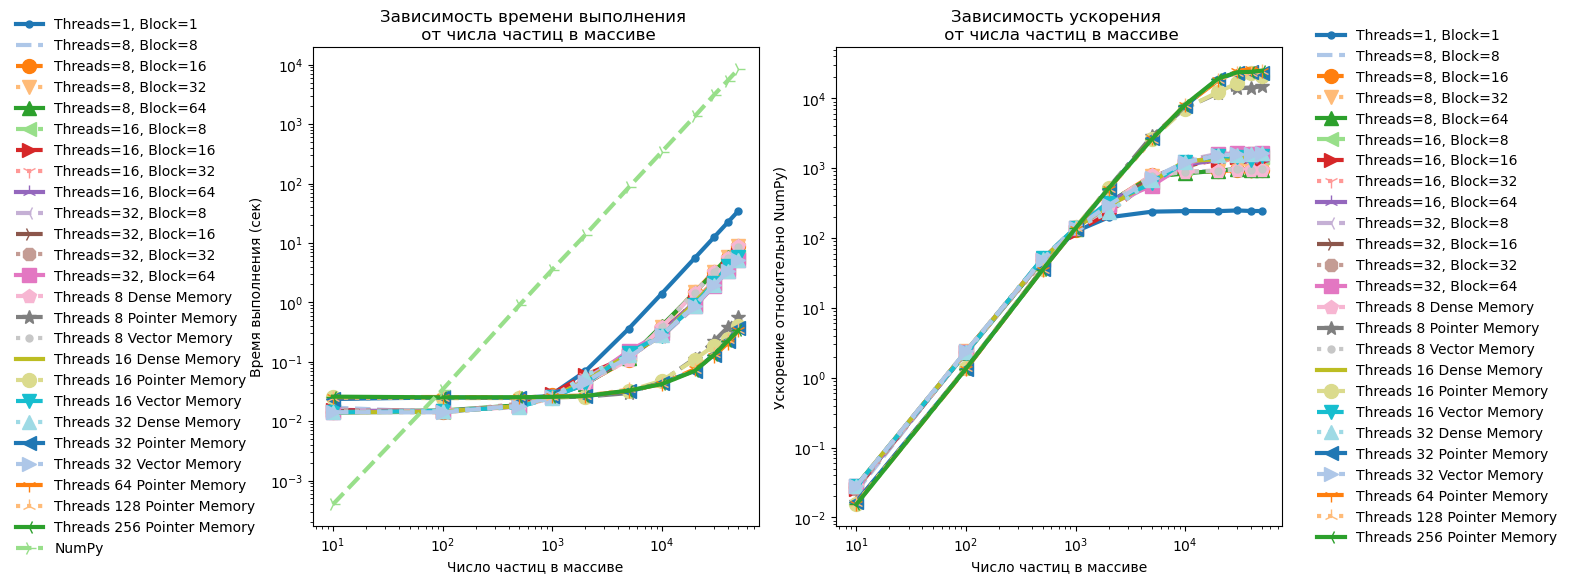

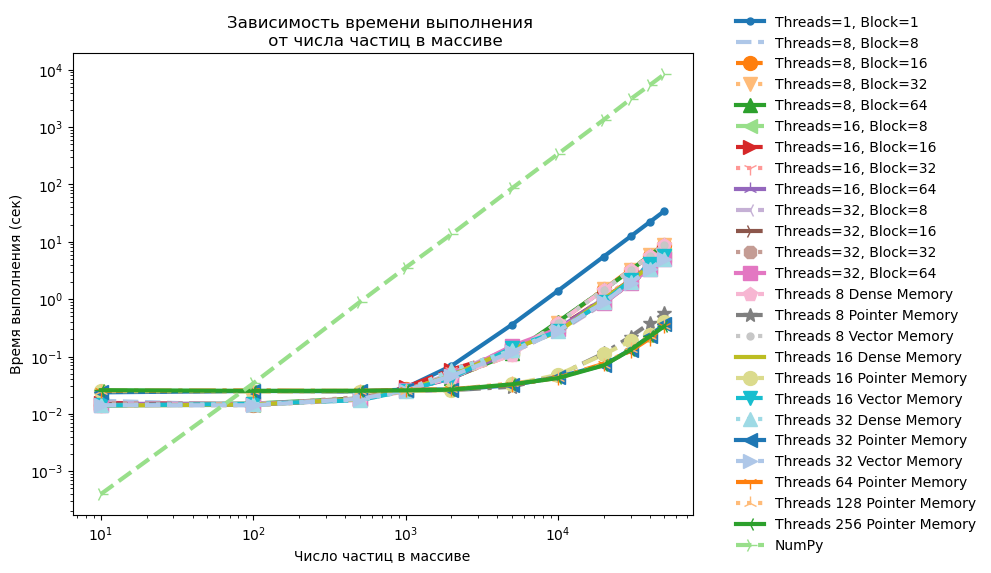

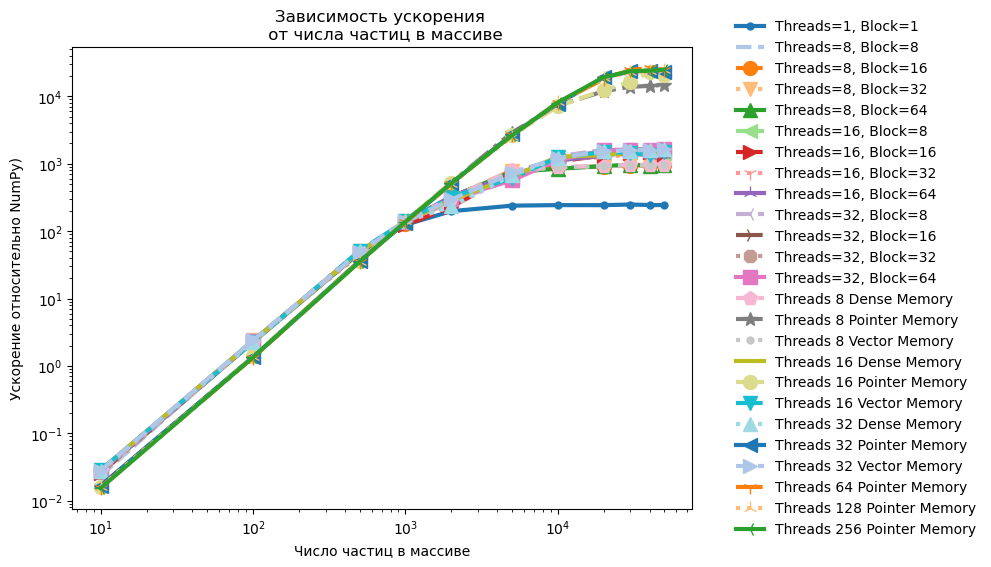

In [9]:
# Построение графиков LOGxLOG
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График времени выполнения
plt.subplot(1, 2, 1)
stl = 0
for label, times in results.items():
    axes[0].plot(particle_counts, times, label=label, **styles[stl],lw=3,ms=10)
    stl += 1
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения \n от числа частиц в массиве")
#plt.legend()
# Добавляем легенду слева от первого subplot
axes[0].legend(
    loc='center right', 
    bbox_to_anchor=(-0.1, 0.5),
    frameon=False
)

plt.subplot(1, 2, 2)
# График ускорения относительно NumPy
stl = 0
for label, times in results.items():
    if label != "NumPy":
        speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
        axes[1].plot(particle_counts, speedup, label=label, **styles[stl],lw=3,ms=10)
    stl += 1
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Ускорение относительно NumPy)")
plt.title("Зависимость ускорения \n от числа частиц в массиве")
#plt.legend()
# Добавляем легенду справа от последнего subplot
axes[1].legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)

plt.tight_layout()
plt.savefig("NumPy_vs_TaiChi_CPU_loglog.png",dpi=600,bbox_inches='tight', pad_inches=0.5)
plt.show()


# График времени выполнения
fig = plt.figure(figsize=(8, 6))
stl = 0
for label, times in results.items():
    plt.plot(particle_counts, times, label=label, **styles[stl],lw=3,ms=10)
    stl += 1
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения \n от числа частиц в массиве")
#plt.legend()
# Добавляем легенду справа 
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)
fig.savefig(f'NumPy_vs_TaiChi_CPU_loglog_subplot_alt_{1}.png', 
                bbox_inches='tight',
                dpi=600, pad_inches=0.5)


# График ускорения относительно NumPy
fig = plt.figure(figsize=(8, 6))
stl = 0
for label, times in results.items():
    if label != "NumPy":
        speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
        plt.plot(particle_counts, speedup, label=label, **styles[stl],lw=3,ms=10)
    stl += 1
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Ускорение относительно NumPy)")
plt.title("Зависимость ускорения \n от числа частиц в массиве")
#plt.legend()
# Добавляем легенду справа 
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)
fig.savefig(f'NumPy_vs_TaiChi_CPU_loglog_subplot_alt_{2}.png', 
                bbox_inches='tight',
                dpi=600, pad_inches=0.5)


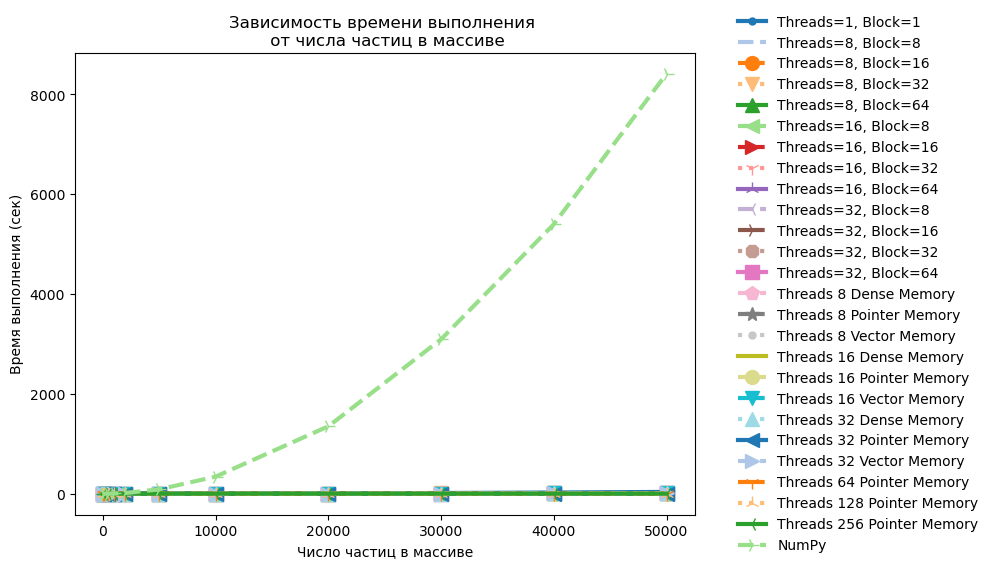

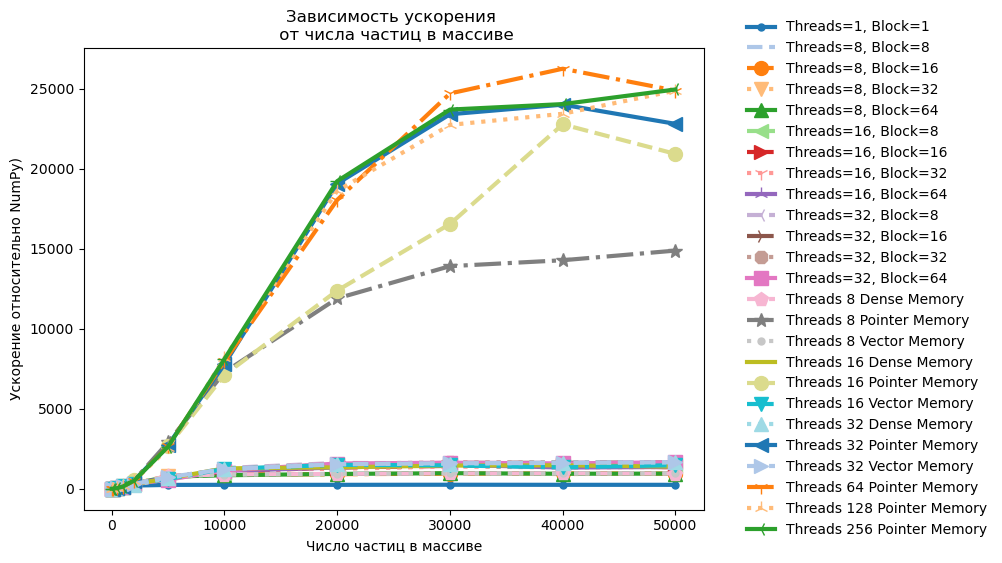

In [8]:
# График времени выполнения SCALxSCAL
fig = plt.figure(figsize=(8, 6))
stl = 0
for label, times in results.items():
    plt.plot(particle_counts, times, label=label, **styles[stl],lw=3,ms=10)
    stl += 1
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения \n от числа частиц в массиве")
#plt.legend()
# Добавляем легенду справа 
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)
fig.savefig(f'NumPy_vs_TaiChi_CPU_scalscal_subplot_alt_{1}.png', 
                bbox_inches='tight',
                dpi=600, pad_inches=0.5)


# График ускорения относительно NumPy SCALxSCAL
fig = plt.figure(figsize=(8, 6))
stl = 0
for label, times in results.items():
    if label != "NumPy":
        speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
        plt.plot(particle_counts, speedup, label=label, **styles[stl],lw=3,ms=10)
    stl += 1
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Ускорение относительно NumPy)")
plt.title("Зависимость ускорения \n от числа частиц в массиве")
#plt.legend()
# Добавляем легенду справа 
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)
fig.savefig(f'NumPy_vs_TaiChi_CPU_scalscal_subplot_alt_{2}.png', 
                bbox_inches='tight',
                dpi=600, pad_inches=0.5)


In [4]:
for label, times in results.items():
    print(F"***********\n{label = }\n{times = }\n")

***********
label = 'Threads=1, Block=1'
times = [0.014143705368041992, 0.014335393905639648, 0.018332481384277344, 0.028441667556762695, 0.06860637664794922, 0.3605053424835205, 1.3993339538574219, 5.548071384429932, 12.43784475326538, 22.104893445968628, 34.51809525489807]

***********
label = 'Threads=8, Block=8'
times = [0.016936302185058594, 0.014124870300292969, 0.018221616744995117, 0.02574896812438965, 0.0417938232421875, 0.11632061004638672, 0.38920140266418457, 1.4592602252960205, 3.181211233139038, 5.652060508728027, 8.71151876449585]

***********
label = 'Threads=8, Block=16'
times = [0.014458417892456055, 0.014289140701293945, 0.01859140396118164, 0.027446985244750977, 0.042874813079833984, 0.10863685607910156, 0.3838818073272705, 1.4838433265686035, 3.292076587677002, 5.63000226020813, 8.9001624584198]

***********
label = 'Threads=8, Block=32'
times = [0.014385700225830078, 0.014089345932006836, 0.017784595489501953, 0.025253772735595703, 0.0424654483795166, 0.1104073524